### Notebook to identify and visualise gene markers for Epithelial cells - Healthy IAV

- **Developed by**: Carlos Talavera-López Ph.D
- **Institute of Computational Biology - Computational Health Centre - Helmholtz Munich**
- v230508

### Import required modules

In [1]:
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 130, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.2
-----
PIL                 9.4.0
appnope             0.1.3
asttokens           NA
backcall            0.2.0
cffi                1.15.1
colorama            0.4.6
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.6
decorator           5.1.1
executing           1.2.0
h5py                3.8.0
igraph              0.10.4
importlib_resources NA
ipykernel           6.21.2
jedi                0.18.2
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.1
llvmlite            0.39.1
louvain             0.8.0
matplotlib          3.7.0
mpl_toolkits        NA
natsort             8.2.0
numba               0.56.4
numexpr             2.8.4
numpy               1.23.5
packaging           23.0
pandas              1.5.3
parso               0.8.3
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
platformdirs        3.0.0
prompt_toolkit      3.0.

### Read in Healthy-CTRL dataset

In [3]:
BrEpit_ALL = sc.read_h5ad('../data/Marburg_All_ctl230404_leiden_states.raw.h5ad') 
BrEpit_ALL

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_cells_by_counts-V5', 'mean_counts-V5', 'pct_dropout_by_coun

### Select condition of interest

In [4]:
BrEpit = BrEpit_ALL[BrEpit_ALL.obs['group'].isin(['healthy_iav'])] 
BrEpit

View of AnnData object with n_obs × n_vars = 22687 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_cells_by_counts-V5', 'mean_counts-V5', 'pct_dropout

### Normalise and transform data

In [5]:
adata_log = anndata.AnnData(X = BrEpit.X,  var = BrEpit.var, obs = BrEpit.obs)
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)
adata_log.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(adata_log, inplace = False)["X"]
)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['BPIFA1', 'MALAT1', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND2', 'MT-ND3', 'MT-ND4', 'MTRNR2L12', 'MTRNR2L8', 'NC_026431.1', 'NC_026432.1', 'NC_026433.1', 'NC_026434.1', 'NC_026435.1', 'NC_026436.1', 'NC_026437.1', 'NC_026438.1', 'SCGB1A1', 'SCGB3A1', 'SLPI']
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


### Calculate marker genes 

In [6]:
sc.tl.rank_genes_groups(adata_log, 'leiden_states', method = 'wilcoxon', n_genes = 100, use_raw = False)
result = adata_log.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcox_markers = pd.DataFrame(
{group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names','logfoldchanges', 'pvals_adj']})
wilcox_markers.head(10)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:42)


,Goblet_0_n,Goblet_0_l,Goblet_0_p,Club_1_n,Club_1_l,Club_1_p,SupraB_2_n,SupraB_2_l,SupraB_2_p,Basal_3_n,...,SupraB_15_p,Mixed_16_n,Mixed_16_l,Mixed_16_p,Mixed_17_n,Mixed_17_l,Mixed_17_p,Club_18_n,Club_18_l,Club_18_p
0,BPIFB1,6.407926,0.0,RDH10,4.662631,0.0,SERPINB13,4.418129,0.0,DST,...,5.498690e-87,SCGB3A1,3.126267,6.009046e-36,NC_026435.1,14.034009,1.702873e-244,KIT,12.279356,4.534552e-69
1,SLPI,3.712287,0.0,B4GALT5,3.378559,0.0,CLCA4,5.203169,0.0,WNT10A,...,6.847053e-76,BPIFB1,3.406263,1.608453e-33,NC_026437.1,13.634648,5.480789e-243,ANXA4,2.804228,1.656383e-66
2,PIGR,6.450871,0.0,WFDC2,3.489963,0.0,SERPINB1,2.746442,0.0,KRT15,...,3.078940e-73,SLPI,1.568755,1.397133e-24,NC_026438.1,13.493216,8.626759e-243,HEPACAM2,11.326824,4.637037e-49
3,XBP1,4.125935,0.0,GSN,2.256634,0.0,CSTA,2.902674,0.0,ALDH3A1,...,9.863211e-73,BPIFA1,2.659807,3.663818e-24,NC_026436.1,11.725740,4.690532e-241,AZGP1,9.636347,5.467058e-49
4,SCGB3A1,5.536752,0.0,GABRP,5.355990,0.0,AQP3,2.669165,0.0,KRT5,...,1.110462e-72,WFDC2,1.964380,9.496750e-20,NC_026434.1,12.584952,4.232100e-240,NREP,6.917747,3.063710e-47
5,WFDC2,4.041477,0.0,GLUL,1.586726,0.0,SERPINB2,4.957524,0.0,IGFBP6,...,4.601328e-70,PIGR,2.946917,4.257288e-18,NC_026431.1,11.461730,2.171940e-238,CRYM,7.900301,4.114566e-45
6,BPIFA1,5.953322,0.0,ALOX15,5.062655,0.0,S100A16,1.722026,0.0,BCAM,...,4.336334e-68,CEACAM6,3.109492,2.117849e-16,NC_026433.1,11.419093,1.558410e-237,FAM43A,6.476193,4.837541e-43
7,CXCL17,3.597788,0.0,CLINT1,2.165089,0.0,RPL14,0.906432,0.0,CCDC3,...,5.027987e-68,LCN2,1.669231,9.482824e-14,NC_026432.1,10.941811,7.181355e-232,SLC6A9,5.140264,6.293359e-42
8,PLEKHS1,5.729818,0.0,ELF3,2.973232,0.0,S100A14,2.136788,0.0,ITGB1,...,4.037427e-67,CYP2F1,2.861566,1.831425e-13,MTRNR2L12,2.956036,1.150517e-183,ATP2A3,9.195553,1.983888e-40
9,AGR2,3.760228,0.0,EPAS1,2.414693,0.0,RPS24,0.764310,0.0,TNFRSF21,...,1.202031e-66,RARRES1,2.567020,1.985689e-13,CNBD1,9.466701,8.344703e-181,MUC20,4.711751,2.194480e-39


In [7]:
wilcox_markers.to_csv('../data/Healthy-IAV_DEG_WRST_ctl230508.csv', index = False, sep = ',')

### Visualise marker genes

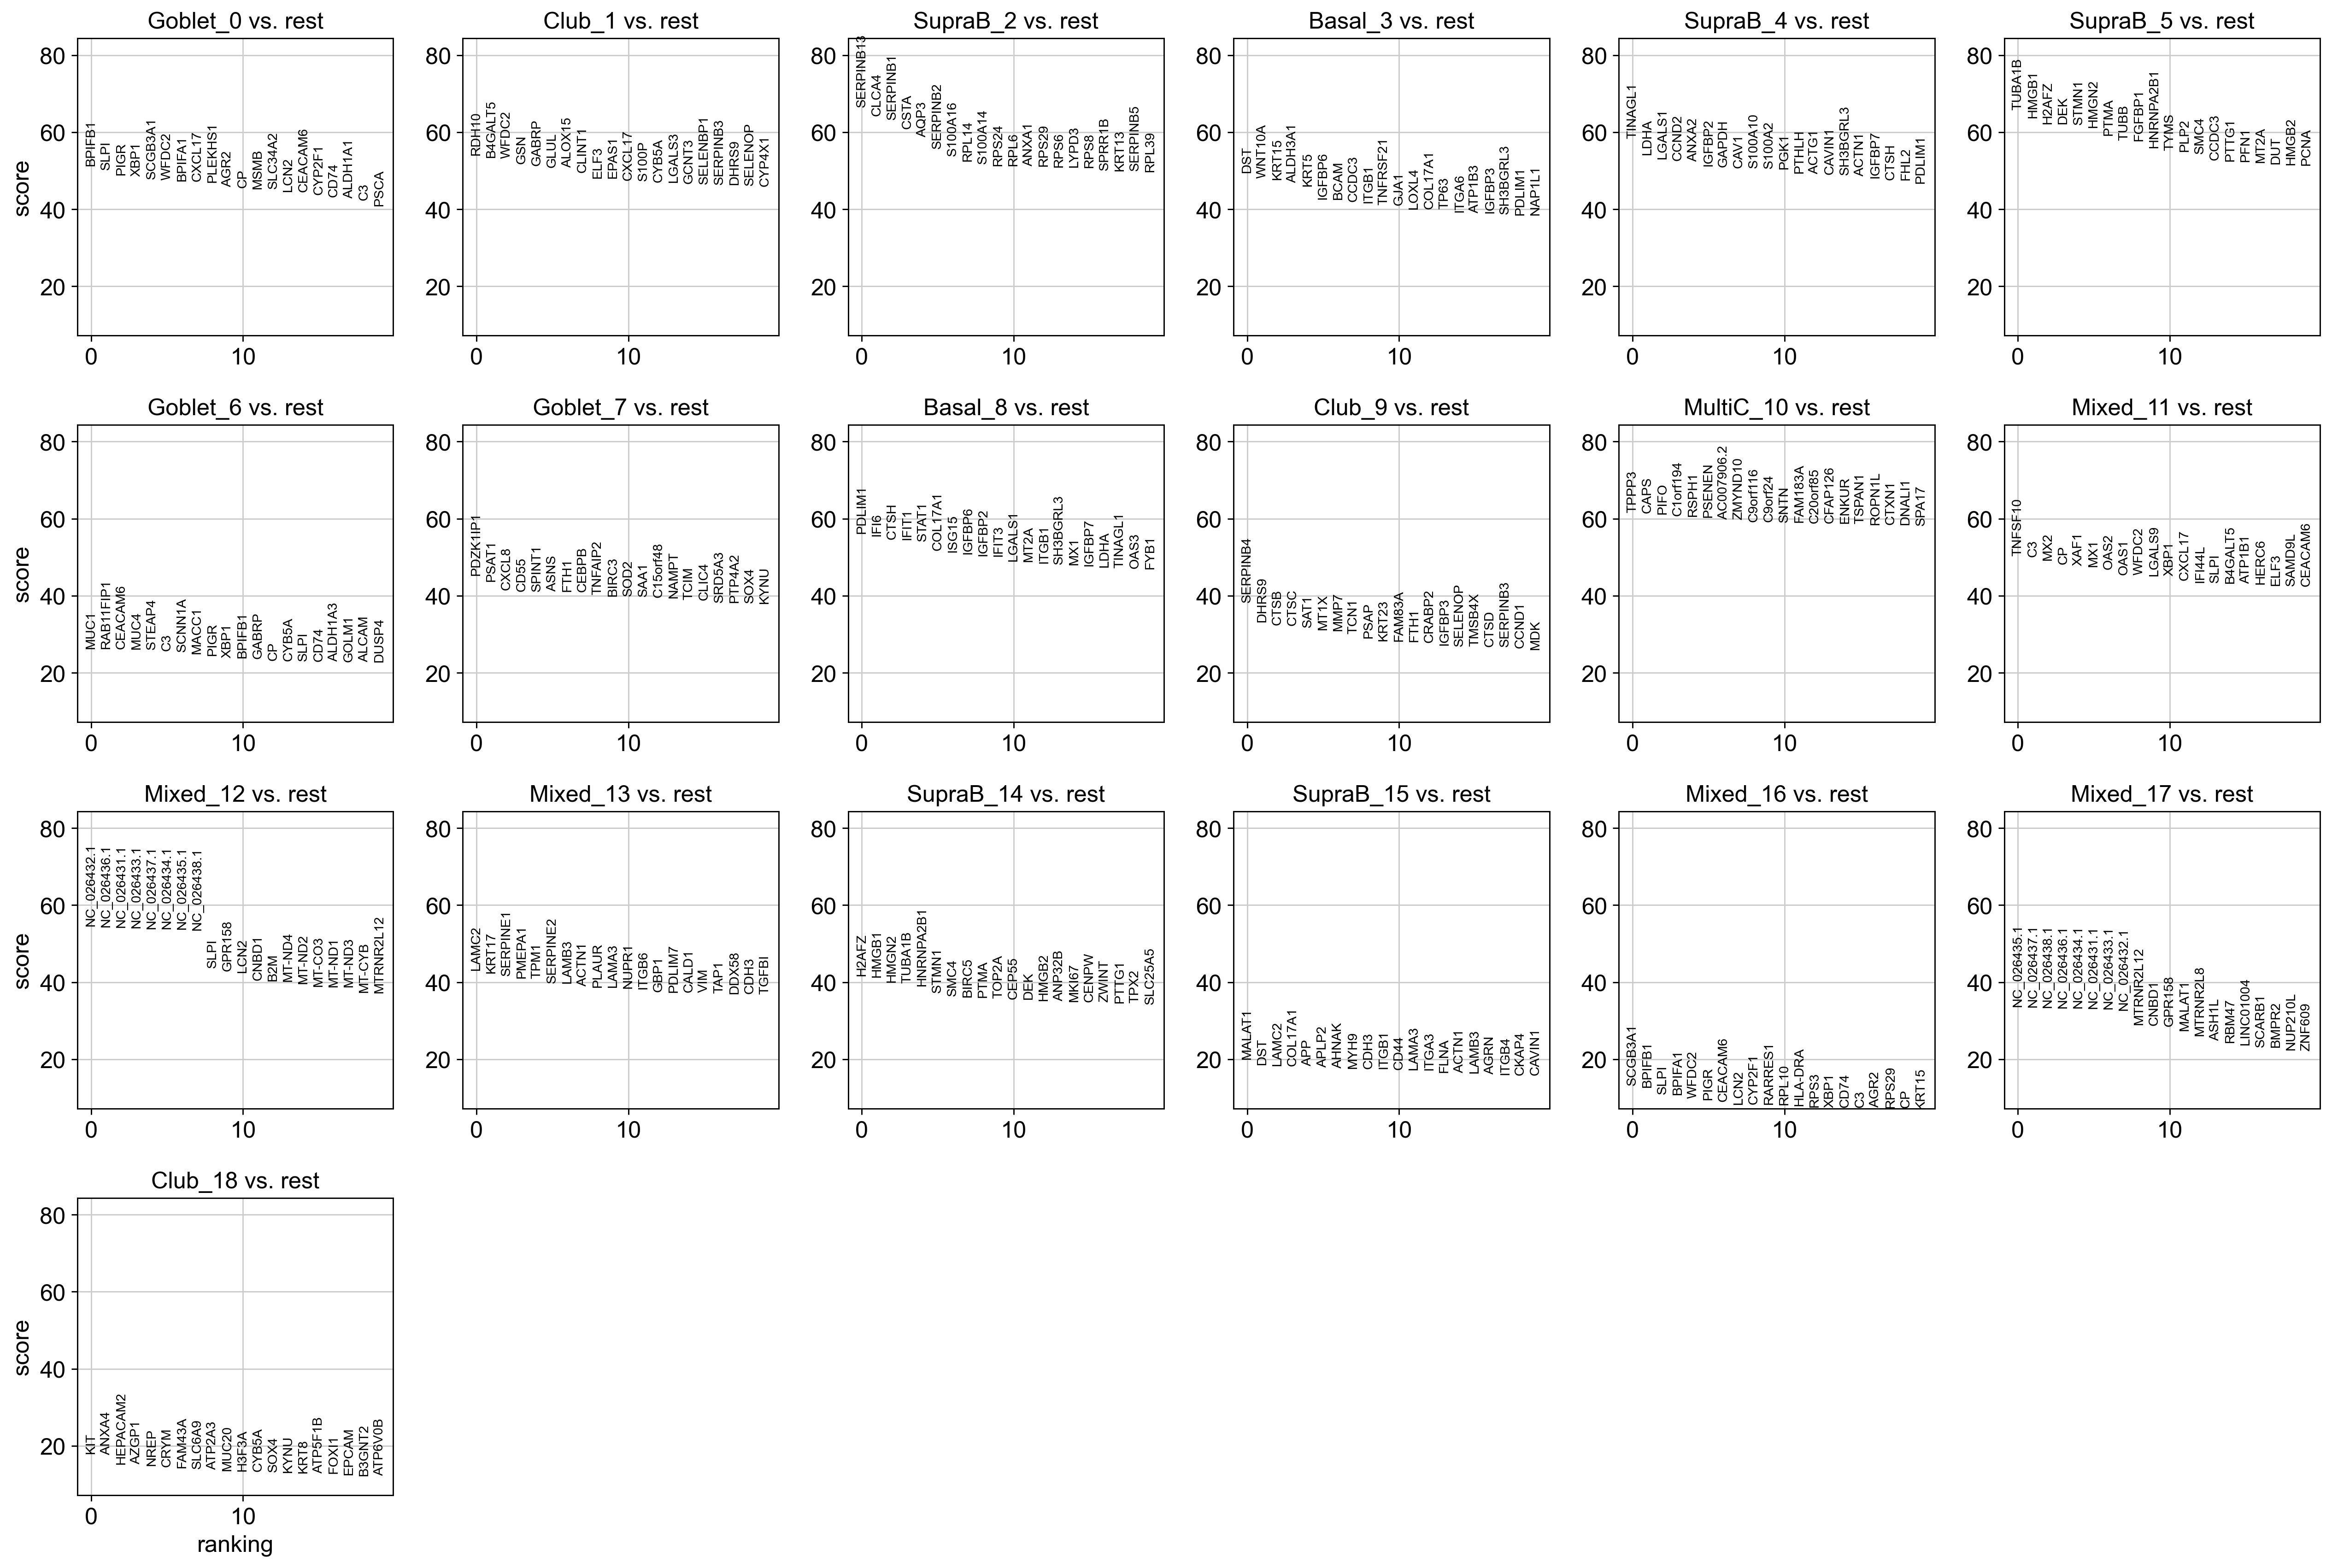

In [8]:
sc.pl.rank_genes_groups(adata_log, ncols = 6)

In [ ]:
markers = ['SERPINE1', 'SERPINE2', 'PMEPA1', 'AMIGO2', 'LGALS1', 'MYL9', 'DKK3', 'MMP2']
sc.pl.stacked_violin(adata_log, markers, groupby = 'group', dendrogram = True, cmap = 'RdPu')

In [ ]:
markers = ['TWIST1', 'FOXC2', 'SNAI1', 'VIM', 'FGFR1']
sc.pl.stacked_violin(adata_log, markers, groupby = 'group', dendrogram = True, cmap = 'RdPu')

In [ ]:
markers = ['TWIST1', 'FOXC2', 'SNAI1', 'VIM', 'FGFR1']
sc.pl.stacked_violin(adata_log, markers, groupby = 'disease', dendrogram = True, cmap = 'RdPu')

In [ ]:
markers = ['TWIST1', 'FOXC2', 'SNAI1', 'VIM', 'FGFR1']
sc.pl.stacked_violin(adata_log, markers, groupby = 'infection', dendrogram = True, cmap = 'RdPu')

In [ ]:
markers = ['TWIST1', 'FOXC2', 'SNAI1', 'VIM', 'FGFR1', 'FN1']
sc.pl.stacked_violin(adata_log, markers, groupby = 'leiden_states', dendrogram = True, cmap = 'RdPu')

### Compare expression

In [ ]:
sc.pl.rank_genes_groups_violin(adata_log,  n_genes = 5, jitter = False, strip = True)

In [ ]:
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)
plt.show()

In [ ]:
BrEpit_ALL

### Rename cluster based on the cell type annotation

In [ ]:
sc.pl.umap(BrEpit_ALL, frameon = False, color = ['leiden', 'cell_type'], size = 1, legend_fontsize = 5, ncols = 3, legend_loc = 'on data')

In [ ]:
BrEpit_ALL.obs['leiden'].cat.categories

In [ ]:
BrEpit_ALL.obs['leiden_states'] = BrEpit_ALL.obs['leiden']
BrEpit_ALL.obs['leiden_states'].cat.categories = ['Goblet_0', 'Stromal_1', 'Club_2', 'BasalR_3', 'Goblet_4', 'SupraB_5', 'SupraB_6', 'Basal_7', 'Goblet_8', 'Goblet_9', 'Club_10', 'Club_11', 'MultiC_12',
       'MultiC_13', 'Goblet_14', 'Club_15', 'Goblet_16', 'Stromal_17', 'SupraB_18', 'GobletClub_19', 'MultiC_20']
sc.pl.umap(BrEpit_ALL, frameon = False, color = ['leiden', 'cell_type', 'leiden_states'], size = 1, legend_fontsize = 5, ncols = 3, legend_loc = 'on data')

In [ ]:
sc.pl.umap(BrEpit_ALL, frameon = False, color = ['cell_type', 'leiden_states'], size = 1, legend_fontsize = 5, ncols = 2)

### Calculate cluster-specific marker genes using _Wilcoxon's Rank Sum Test_

In [ ]:
BrEpit_ALL_log = BrEpit_ALL.copy()
BrEpit_ALL_log

In [ ]:
sc.pp.normalize_total(BrEpit_ALL_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(BrEpit_ALL_log)

In [ ]:
sc.tl.rank_genes_groups(BrEpit_ALL_log, 'leiden_states', method = 'wilcoxon', n_genes = 100, use_raw = False)
result = BrEpit_ALL_log.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcox_markers = pd.DataFrame(
{group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names','logfoldchanges', 'pvals_adj']})
wilcox_markers.head(10)

### Export annotated object

In [ ]:
BrEpit_ALL

In [ ]:
sc.pl.umap(BrEpit_ALL, frameon = False, color = ['leiden_states', 'STEAP4', 'CEP55', 'FOXJ1', 'PIGR', 'SERPINE2', 'ADM2', 'WNT10A'], size = 1, legend_fontsize = 5, ncols = 4, legend_loc = 'on data')